<a href="https://colab.research.google.com/github/anas-ansri/QuantumComputing/blob/master/cnn_tut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import tensorflow_datasets as tfds

TensorFlow has the food 101 dataset already. We will use this! https://www.tensorflow.org/datasets/catalog/food101

Hot dog is label 55

In [ ]:
ds, ds_info = tfds.load('food101', shuffle_files=True, as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete2DKJEC/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete2DKJEC/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
train_ds, valid_ds = ds["train"], ds["validation"]

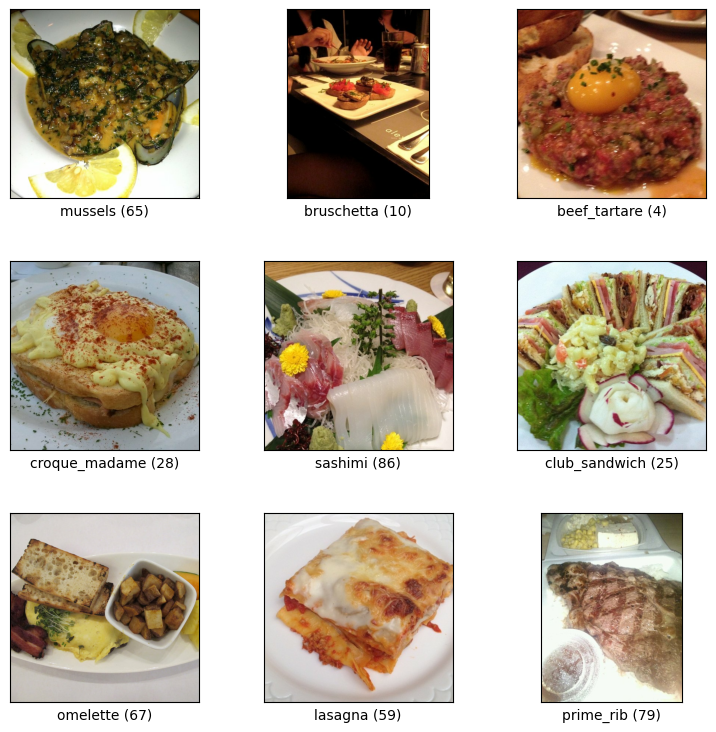

In [ ]:
fig = tfds.show_examples(train_ds, ds_info)

In [ ]:
MAX_SIDE_LEN  = 128
HOT_DOG_CLASS = 55

#Transforming all images to square and labeling
train_ds = train_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), tf.int32),
                          tf.cast(label == HOT_DOG_CLASS, tf.int32))
)

valid_ds = train_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]),tf.int32),
                          tf.cast(label == HOT_DOG_CLASS, tf.int32))
)

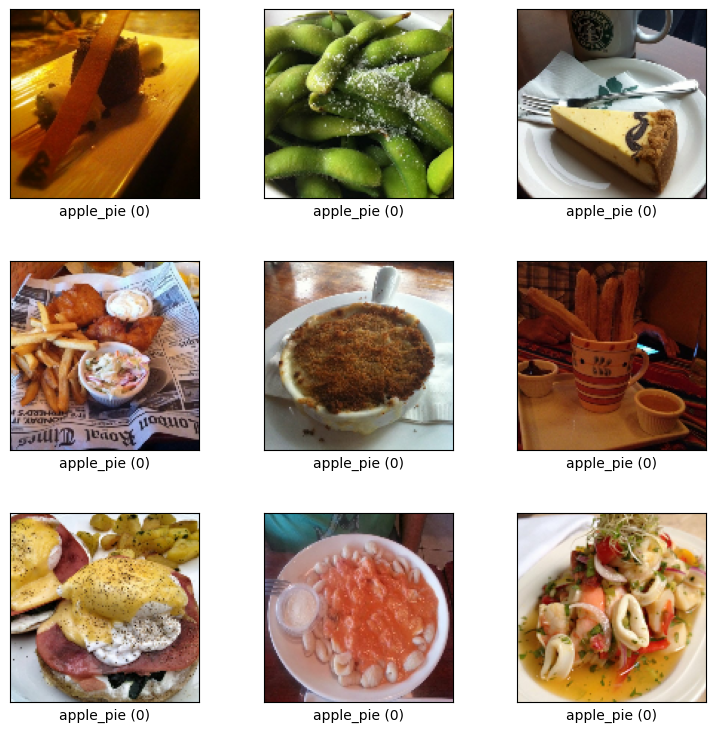

In [ ]:
fig = tfds.show_examples(train_ds, ds_info)

In [ ]:
#Rebalancing dataset

train_hd_size, validation_hd_size = 750, 250 #From ds documantation
train_hotdogs = train_ds.filter(lambda image, label: label == 1).repeat(3)
train_nothotdogs = train_ds.filter(lambda image, label: label == 0)

In [ ]:
valid_hotdogs = train_ds.filter(lambda image, label: label == 1).repeat(3)
valid_nothotdogs = train_ds.filter(lambda image, label: label == 0)

In [ ]:
batch_size = 16


train_ds  = tf.data.Dataset.sample_from_datasets([train_hotdogs, train_nothotdogs],
                                                 [0.5, 0.5],
                                                 stop_on_empty_dataset = True
                                                 )


train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

#For valid ds
valid_ds  = tf.data.Dataset.sample_from_datasets([valid_hotdogs, valid_nothotdogs],
                                                 [0.5, 0.5],
                                                 stop_on_empty_dataset = True
                                                 )


valid_ds = valid_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
for image_batch, label_batch in train_ds.take(1):
  print(image_batch.shape)
  print(label_batch)

(16, 128, 128, 3)
tf.Tensor([0 0 0 1 0 0 0 1 0 1 1 1 1 1 0 1], shape=(16,), dtype=int32)


#Neural Net Implementation

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
for i, _ in ds['train'].take(1):
  image = i

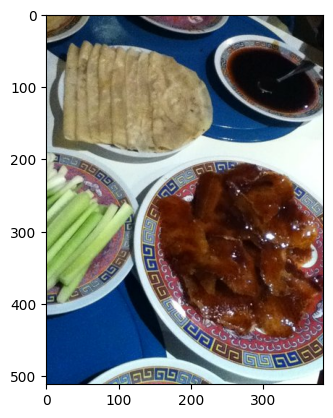

In [ ]:
plt.imshow(image)

In [ ]:
image = tf.cast(tf.expand_dims(image, 0), tf.float32)
image /= 255.0

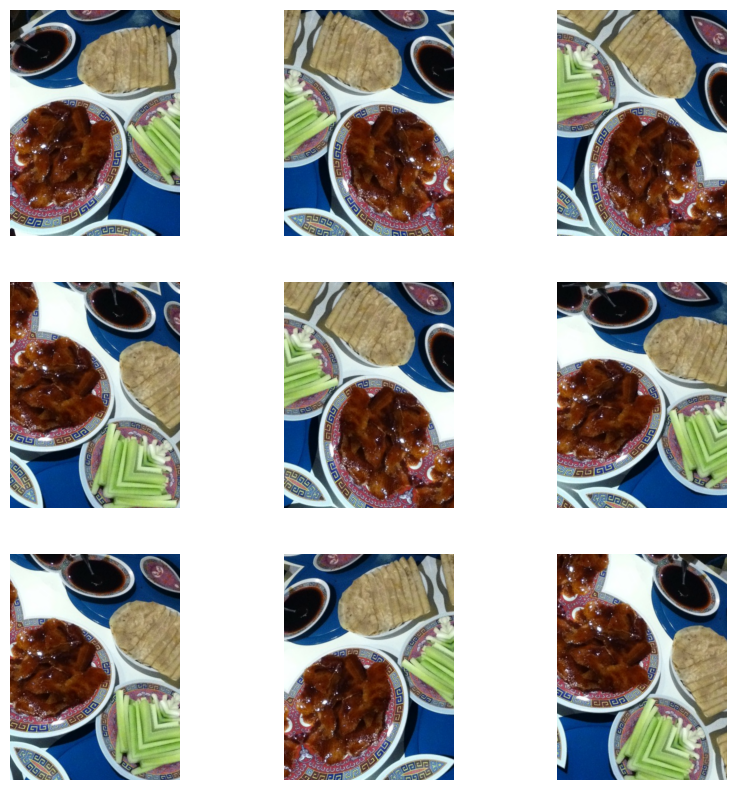

In [ ]:
plt.figure(figsize=(10,10))

for i in range(9):
  augumented_image  = data_augmentation(image)
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(augumented_image[0])
  plt.axis('off')

In [ ]:
random.seed(0)

model = models.Sequential()
model.add(layers.Rescaling(1./255))
model.add(data_augmentation)
model.add(layers.Conv2D(64, (3,3), activation='relu', input_shape= [MAX_SIDE_LEN, MAX_SIDE_LEN, 3]))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer = tf.keras.regularizers.l2(l = 0.01)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer = tf.keras.regularizers.l2(l = 0.01)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1))

In [ ]:
lr = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss = tf.keras.losses.BinaryCrossentropy(from_logits= True), metrics = ['accuracy'])

In [ ]:
epochs = 50
history = model.fit(
    train_ds,
    validation_data = valid_ds,
    epochs = epochs,
    verbose =1
)

Epoch 1/50
279/279 [==============================] - 12s 28ms/step - loss: 1.4341 - accuracy: 0.4979 - val_loss: 1.1734 - val_accuracy: 0.5085
Epoch 2/50
279/279 [==============================] - 8s 29ms/step - loss: 1.0242 - accuracy: 0.4997 - val_loss: 0.9087 - val_accuracy: 0.5090
Epoch 3/50
279/279 [==============================] - 7s 25ms/step - loss: 0.8514 - accuracy: 0.5237 - val_loss: 0.7990 - val_accuracy: 0.5210
Epoch 4/50
279/279 [==============================] - 7s 25ms/step - loss: 0.7773 - accuracy: 0.5346 - val_loss: 0.7453 - val_accuracy: 0.5408
Epoch 5/50
279/279 [==============================] - 7s 26ms/step - loss: 0.7388 - accuracy: 0.5530 - val_loss: 0.7152 - val_accuracy: 0.5618
Epoch 6/50
279/279 [==============================] - 8s 30ms/step - loss: 0.7155 - accuracy: 0.5638 - val_loss: 0.6925 - val_accuracy: 0.5843
Epoch 7/50
279/279 [==============================] - 7s 25ms/step - loss: 0.7011 - accuracy: 0.5705 - val_loss: 0.6763 - val_accuracy: 0.576

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in valid_ds.take(1):
  images = image_batch
  labels = label_batch

<Figure size 1000x1000 with 0 Axes>

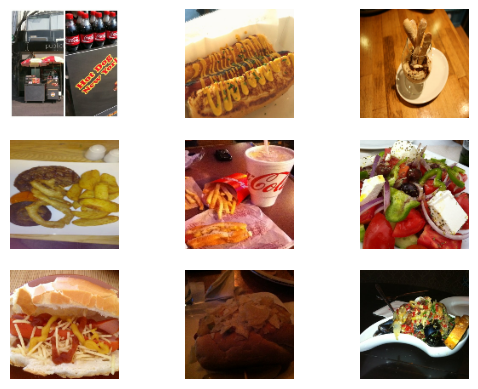

In [ ]:
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(images[i])
  plt.axis('off')

In [ ]:
labels[:9]

<tf.Tensor: shape=(9,), dtype=int32, numpy=array([1, 1, 0, 0, 1, 0, 1, 1, 0], dtype=int32)>